# 1. introduction

## 2. Data Collection and Pre-processing

### 2.1 Main Challenge
The raw data collected in the previous experiment consisted of 15 contiguous gameplay sessions recorded in a single video file. This presented a significant noise challenge: the recording contained loading screens, menu navigations, and three distinct boss phases (Potato, Onion, Carrot), each requiring different visual recognition patterns and reflex strategies.

To train a specialized agent, I needed to isolate the **Potato Phase**—the specific segment where the player must dodge projectiles (dirt clods) and jump over obstacles.
I created segmentation script and filtered dataset genreator to solve this problem 
# (see appendix X)


## 3. Methodology: Pivoting from Generalization to Micro-Timing

### 3.1 Refinement of Scope
In Assignment 2, the "General Cuphead Agent" achieved high accuracy (96%) but failed functionally because it prioritized the majority class (shooting) and struggled to "see" small, high-velocity threats in the Autoencoder's latent space.

For this final experiment, I pivoted from a broad strategy (playing the whole game) to a focused **micro-timing analysis**. The core research question shifted:
> *Does Explicit Perception (Object Detection) outperform Implicit Perception (Latent Representation) in high-speed reaction tasks?*


[need to modify this because i am setting up RL from unity too]

To answer this, I restricted the domain to the **Potato Phase**. This phase is mechanically deterministic but visually demanding, making it the perfect "lab environment" to compare how well different vision architectures can track projectile velocity and trigger a jump action.



### 3.2 Model Selection and Architecture Comparison

I designed two distinct pipelines to compete against each other:

#### **Pipeline A: The Baseline (Implicit Perception)**
*   **Vision:** Convolutional Autoencoder (CAE).
*   **Decision:** Gated Recurrent Unit (GRU).
*   **Rationale:** This represents the "End-to-End" Deep Learning approach. The model is not told what a "bullet" is; it must learn to represent valid game states in a latent vector $z$. The GRU is necessary here to infer velocity, as a single static frame's latent vector does not contain motion information. The RNN must "remember" the previous latent states to understand if an object is moving toward the player.


# make CAE GRU for potato phase

#### **Pipeline B: The Novel Approach (Explicit Perception via YOLO)**
*   **Vision:** **YOLOv8 (You Only Look Once)**.
*   **Decision:** Multi-Layer Perceptron (MLP).
*   **Rationale:** This is the novel technique introduced for this assignment. Instead of relying on the neural network to figure out what pixels matter, we explicitly teach it.
    1.  **Object Detection:** YOLO detects discrete entities: `Cuphead`, `Potato`, and `Projectile`.
    2.  **State Extraction:** We convert bounding boxes into a structured state vector containing **Physics Features** (Distance to projectile, Relative Velocity).
    3.  **Logic:** Because we explicitly calculate velocity from the YOLO detections across frames ($v = \frac{\Delta x}{\Delta t}$), we do **not** need a complex Recurrent Neural Network (GRU). A simple Feed-Forward Network (MLP) should be sufficient to map the state vector $[x, y, v_x, v_y]$ to the action `JUMP`.

#### **Pipeline C: Unity RL **

# detail explanation

# YOLO + MLP
### YOLO

### Mathematical explanation
first attempt

randomly selected 50 images and labeled it (out of about 2000 frames)


how do i check the accuracy?? idk i think i can compare it with the final version


with confidence of 0.4,

but now it barely detects, potato is detected very well but other ones are not detected, bc potato is always present and it doesn't change a lot but cuphead moves and projectile also moves?? idk

![image copy 3.png](<attachment:image copy 3.png>)


so i changed it with confidence of 0.1, it is detected very well

i think it will be nice to have visualization of confidence level of 0.1 and 0.4 and comopare some random frame (3-4 of them)
also, it would be nice to compare the matrics (in how many frames does cuphead exists? potato exists? idk good evaluation metrics? average confidence level? ( i think it's around 0.2 to 0.3 for cuphead))



### **3.4 Result Discussion**

#### 3.4.1 YOLO (Vision Model)

Quantitative analysis of the YOLOv8 performance reveals a significant disparity in feature detectability between class objects. As shown in **Table 1**, the model exhibits near-perfect detection for the 'Potato' class (Avg Confidence: 0.965), which is characterized by a large spatial footprint and distinct texture.

In contrast, the 'Cuphead' and 'Projectile' classes—which are essential for survival logic—yield significantly lower average confidence scores of **0.31** and **0.33** respectively.

| Class Name | Avg Confidence |
| :--- | :--- |
| **Potato** | **0.9655** |
| Cuphead | 0.3100 |
| **Projectile** | **0.3327** |


*Table 1: YOLOv8 Detection Metrics (code in Appendix A)*

This disparity necessitates a deviation from standard YOLO implementation. While default confidence thresholds are typically set to 0.25 or 0.40, our **F1-Confidence Curve analysis (Figure 1)** indicates that the optimal trade-off between precision and recall for this dataset occurs at a threshold of **0.131**.

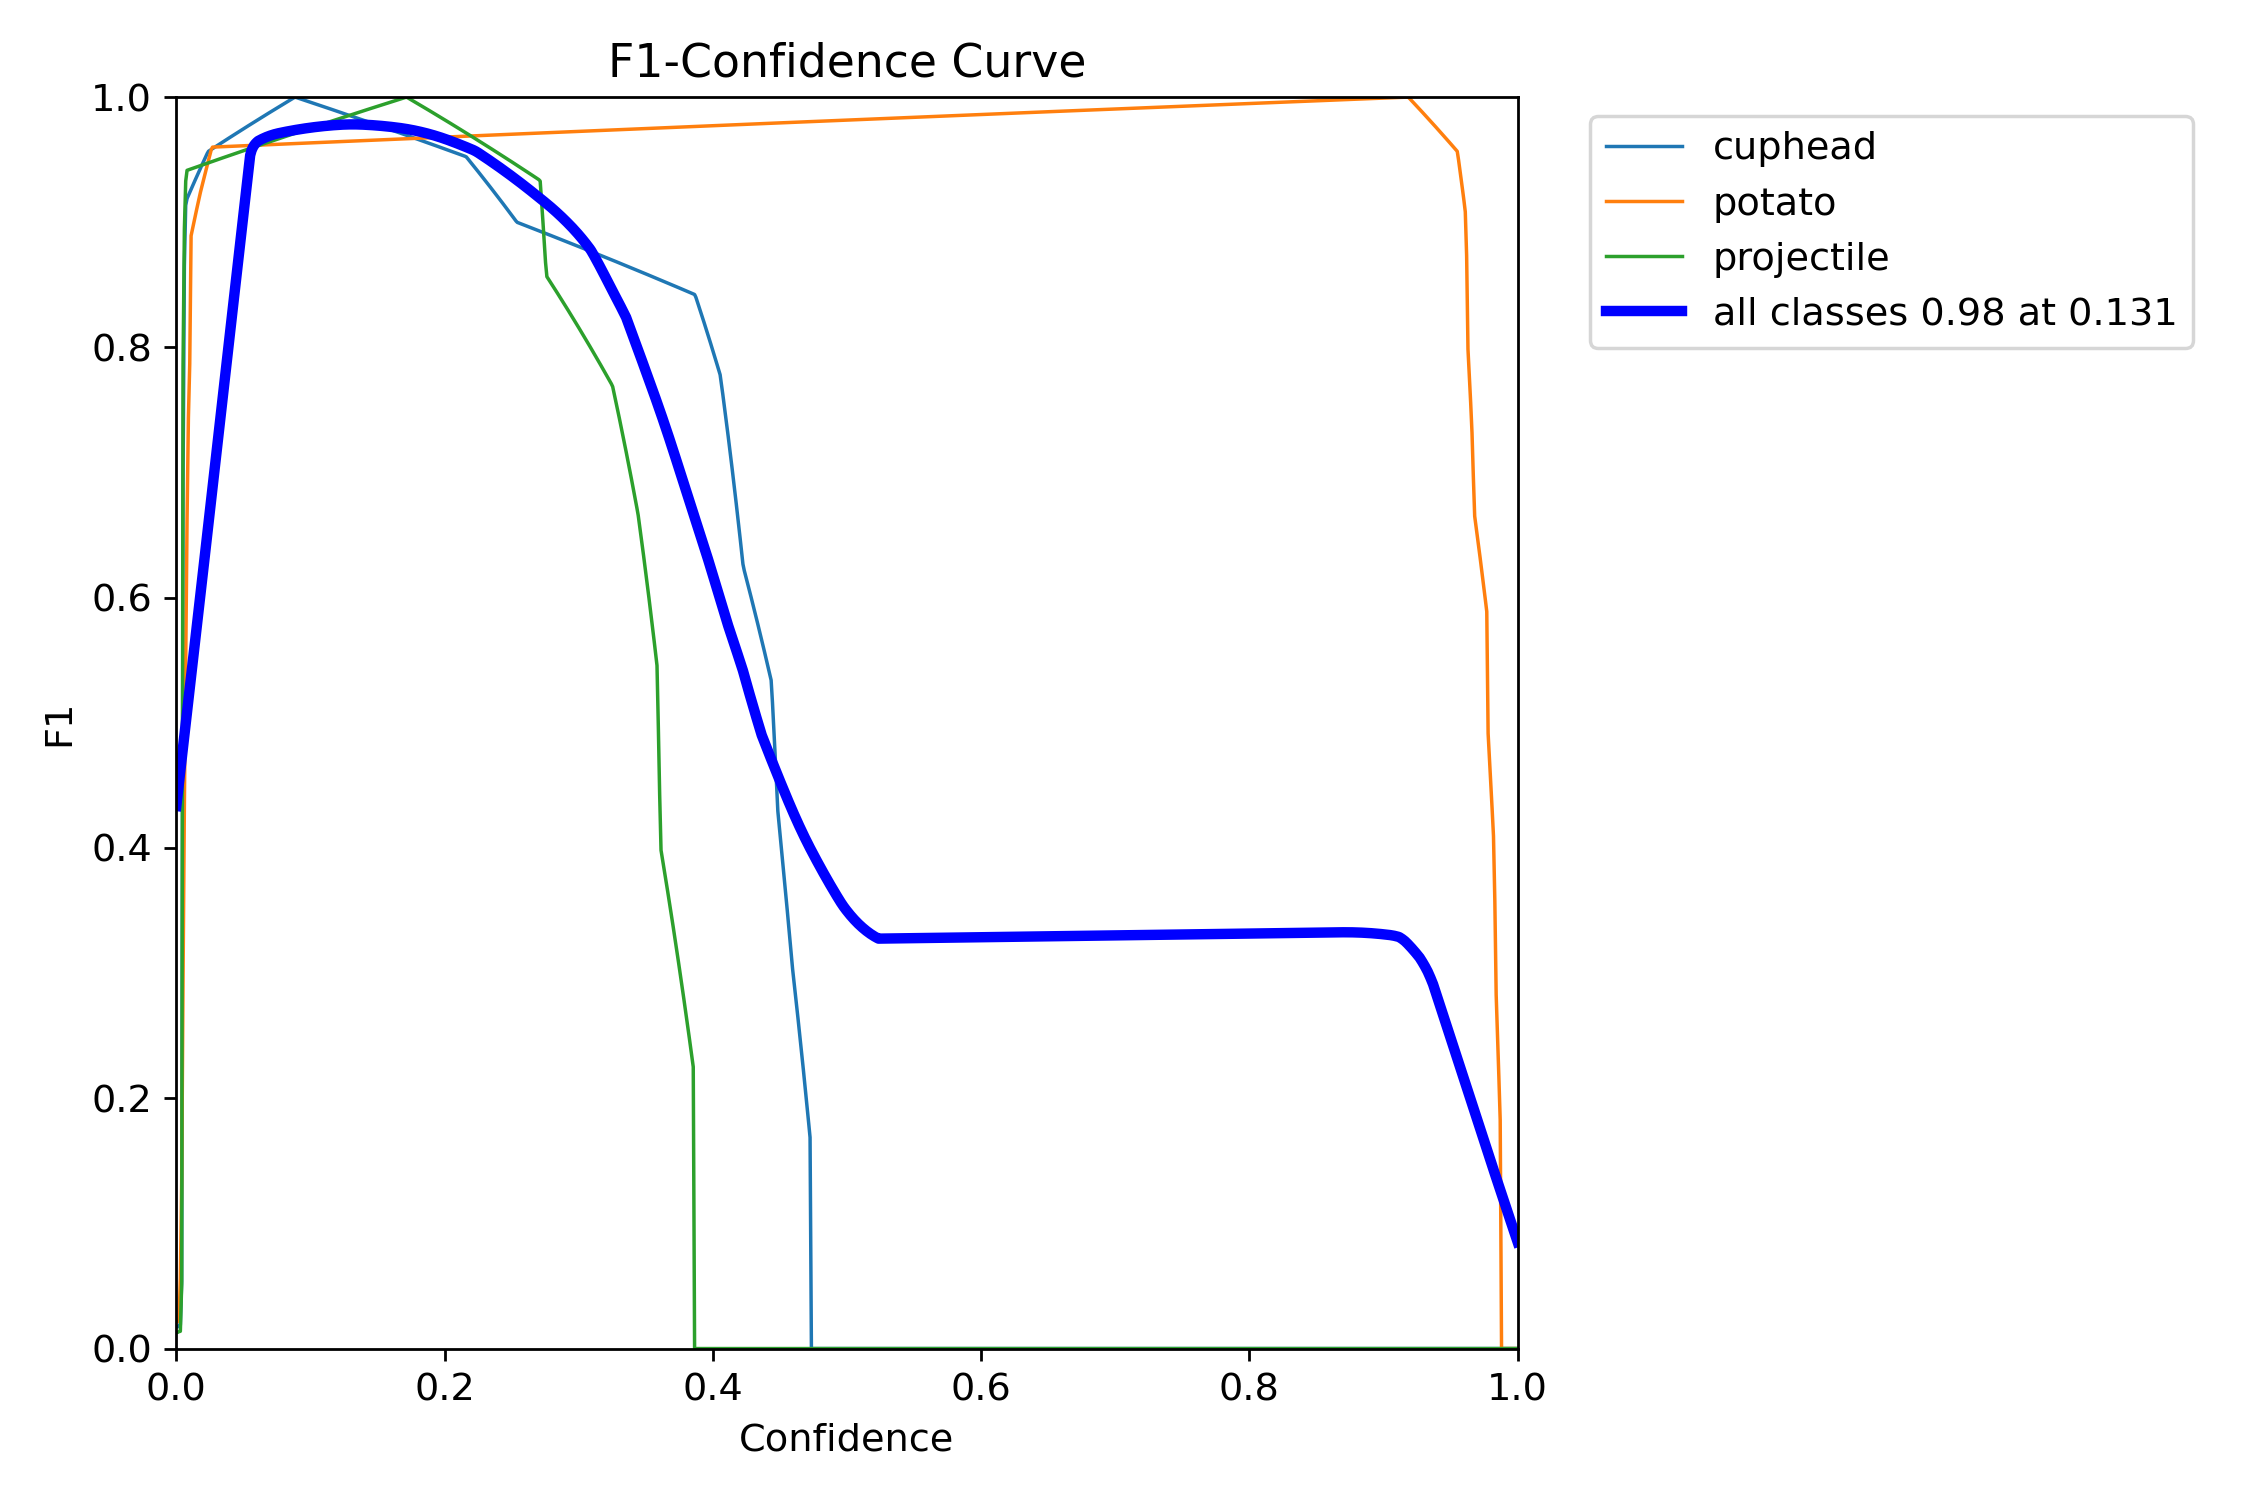
*Figure 1: F1-Confidence Curve analysis*


*   At a threshold of 0.4, the model has detection rate near zero for projectiles. By lowering the threshold to 0.1, we recover the projectile detections required for the physics engine, albeit with a slight increase in bounding box jitter.
*   The Normalized Confusion Matrix (**Figure 2**) confirms that the model's primary failure mode is not misclassification (e.g., confusing Cuphead for a Potato), but rather **False Negatives**. Approximately 12% of projectile instances are misclassified as "Background," primarily due to motion blur and the object's color.

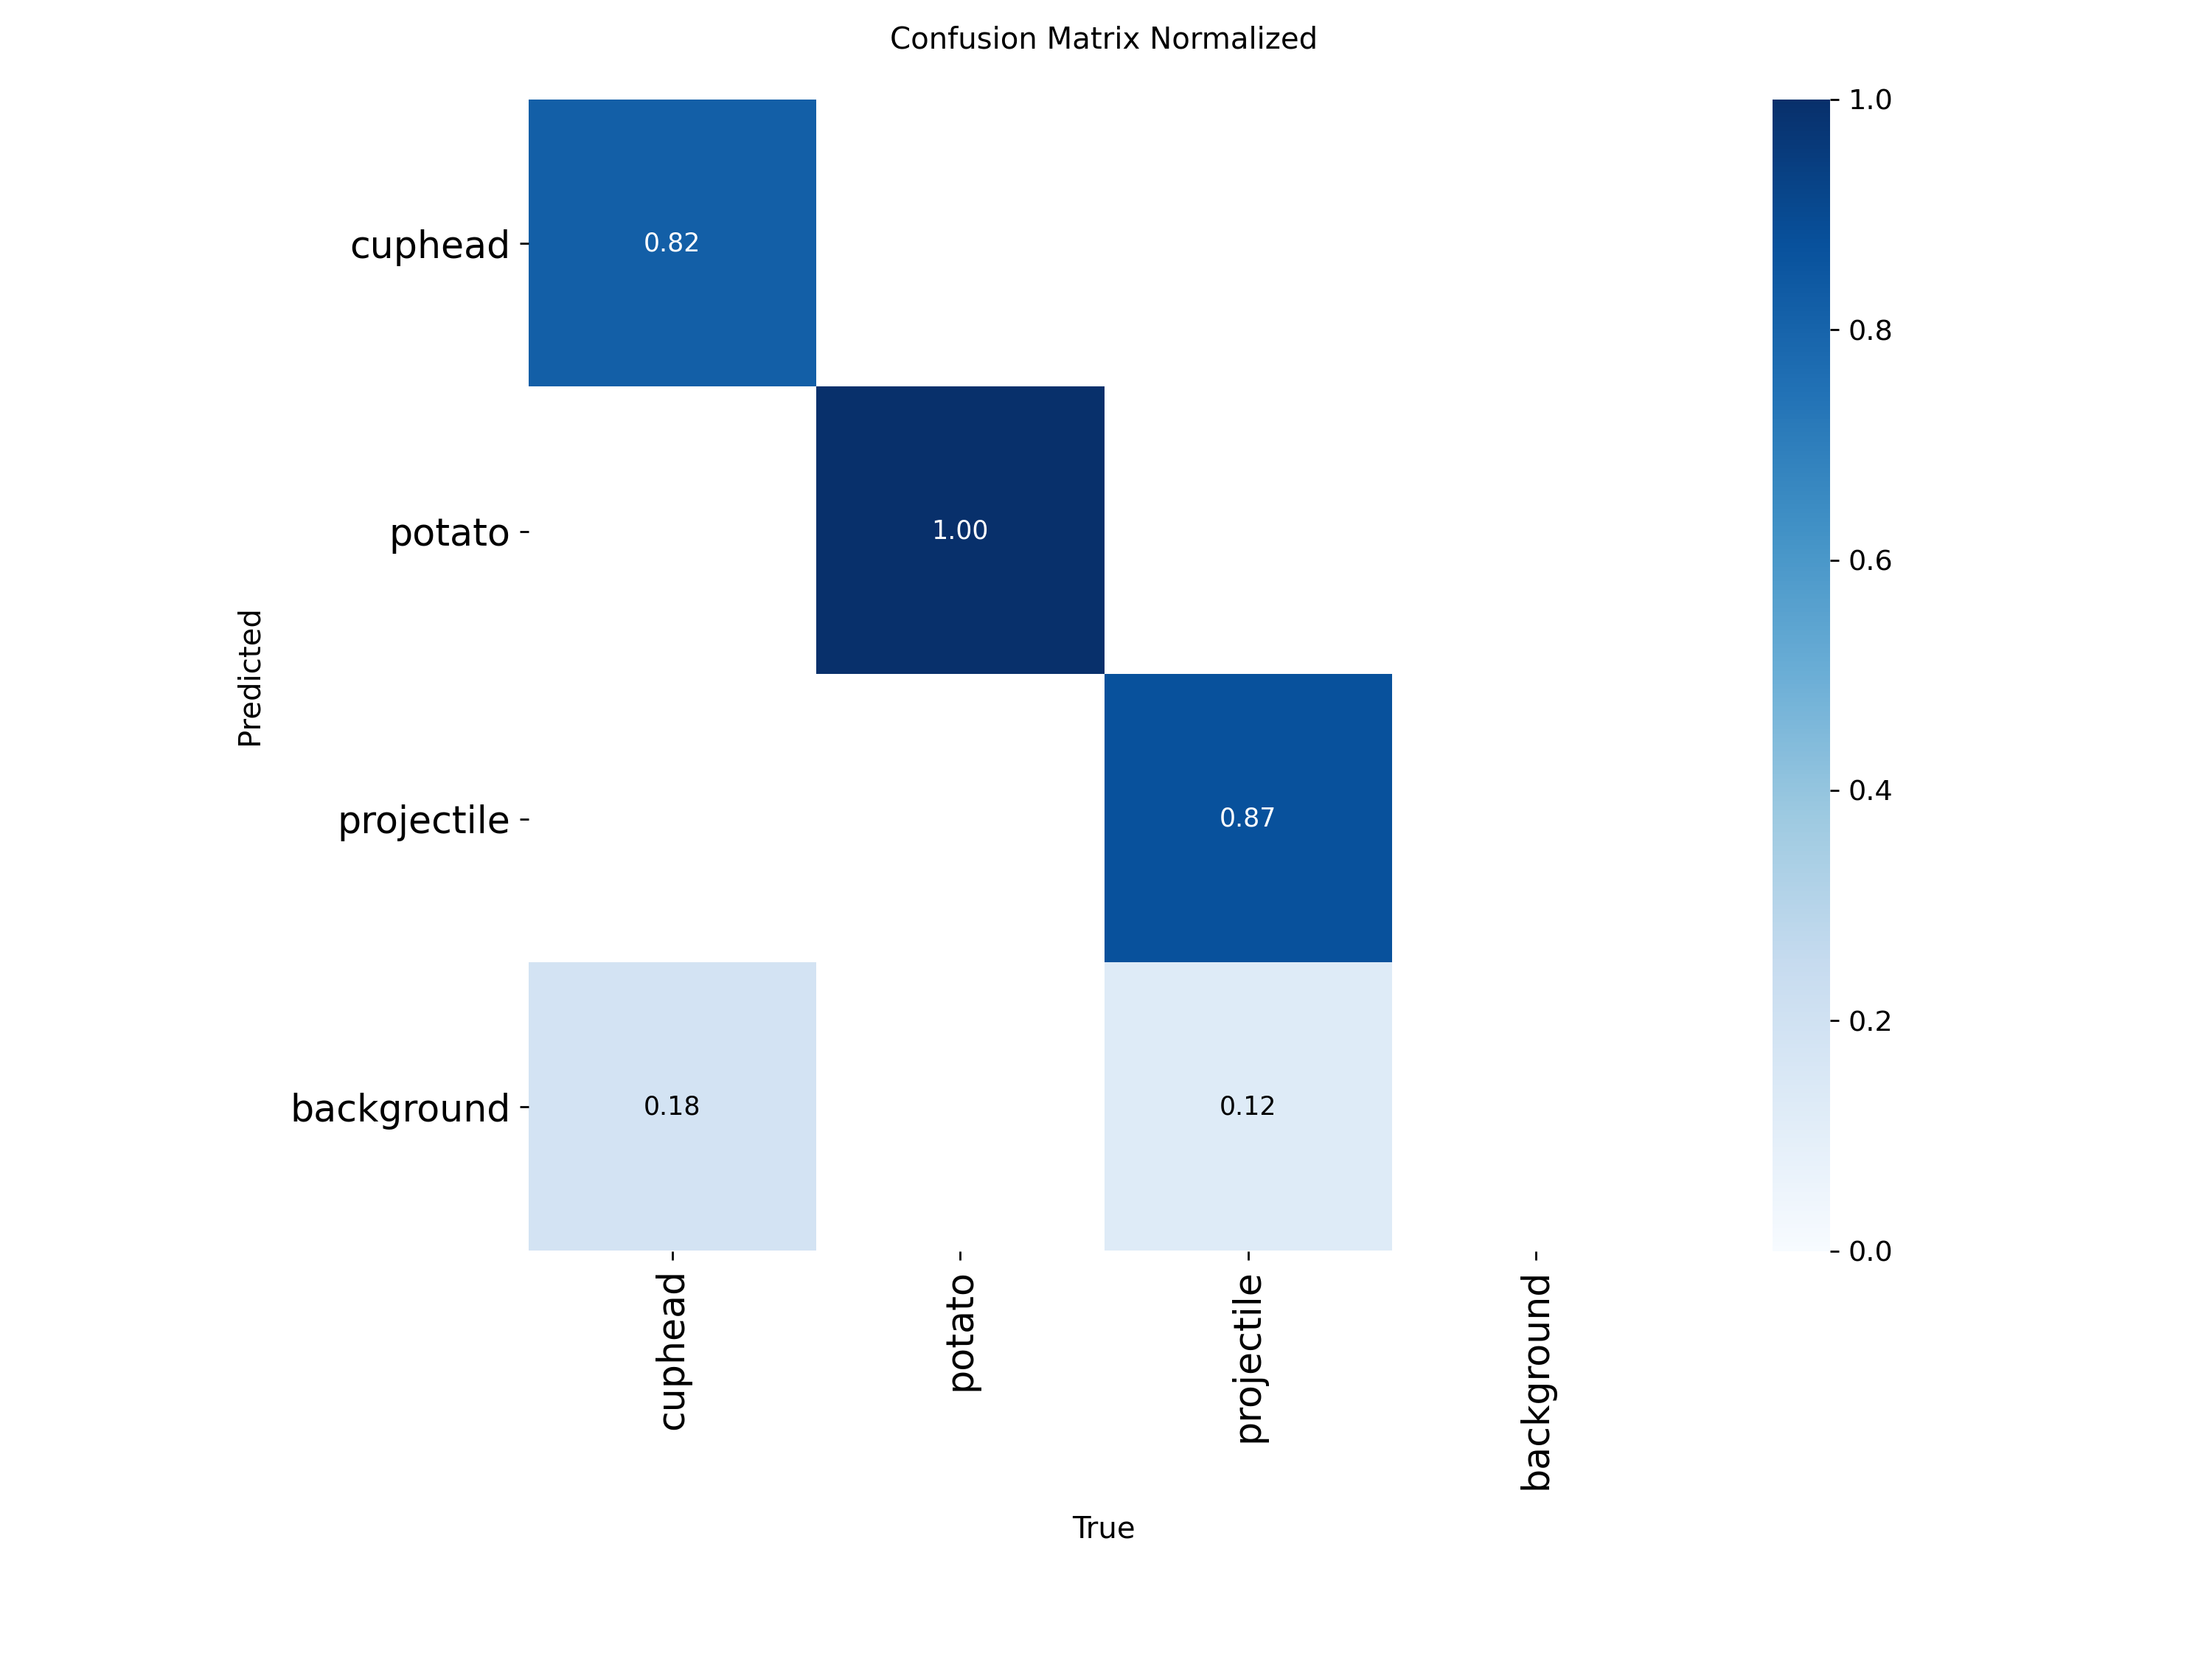
*Figure 2: YOLO Normalized Confusion Matrix*

#### 3.4.2 MLP (Decision Model)
The MLP decision model, trained on the state vector $S_t = [\Delta x, \Delta y, v_x]$, successfully learned a non-linear decision boundary for the "Jump" action.

![MLP Decision Boundary Heatmap.png](<attachment:MLP Decision Boundary Heatmap.png>)

*Figure 3: MLP Decision Boundary Heatmap*

Figure 3 visualizes the model's learned logic. The red region (High Jump Probability) corresponds to states where the projectile is both **close** (Distance < 200px) and **approaching fast** (Velocity > 10px/frame). The gradient transition from green (Idle) to red (Jump) demonstrates that the model is not acting randomly, but has approximated the underlying physics of a collision.

As shown in **Figure 4** and **Table 2**, I changed the decision threshold from the standard 0.50 to **0.786** for a more precise agent.


![MLP confusion matrix.png](<attachment:MLP confusion matrix.png>)
*Figure 4: MLP Confusion Matrix*

| Metric | Standard (0.50) | Optimized (0.786) | Impact |
| :--- | :--- | :--- | :--- |
| Accuracy | 0.90 | 0.92 | +2% Improvement |
| Jump Precision | 0.59 | 0.67 | Reduced False Positives |
| Jump Recall | 0.95 | 0.83 | Slight trade-off |

*Table 2: MLP Performance Comparison*

The optimized model achieves a **Precision of 0.67** on the Jump class, meaning it is less likely to panic jump when no threat is present, while maintaining a Recall of 0.83, ensuring it reacts to the vast majority of incoming threats.



### **3.4.3 Behavioral Generalization**

To evaluate the Agent's performance across the entire dataset, I visualized the jumping patterns for all training and validation segments. **As shown in the full timeline (Figure 5), the AI (Red) exhibits a highly similar pattern to the Human (Green) across the majority of sessions.** This consistent alignment confirms that the MLP successfully captured the rhythmic nature of the Potato’s projectile phase. 

![MLP full timeline.png](<attachment:MLP full timeline.png>)
*Figure 5: Overview of Human vs. AI Jump Actions across 15 sessions.*

However, to verify that the agent has learned a generalized policy based on physics rather than simply memorizing this temporal rhythm ($Action \neq f(Time)$), I conducted a detailed comparative analysis between a "Perfect Run" (Session 10) and a "Failed Run" (Session 9).

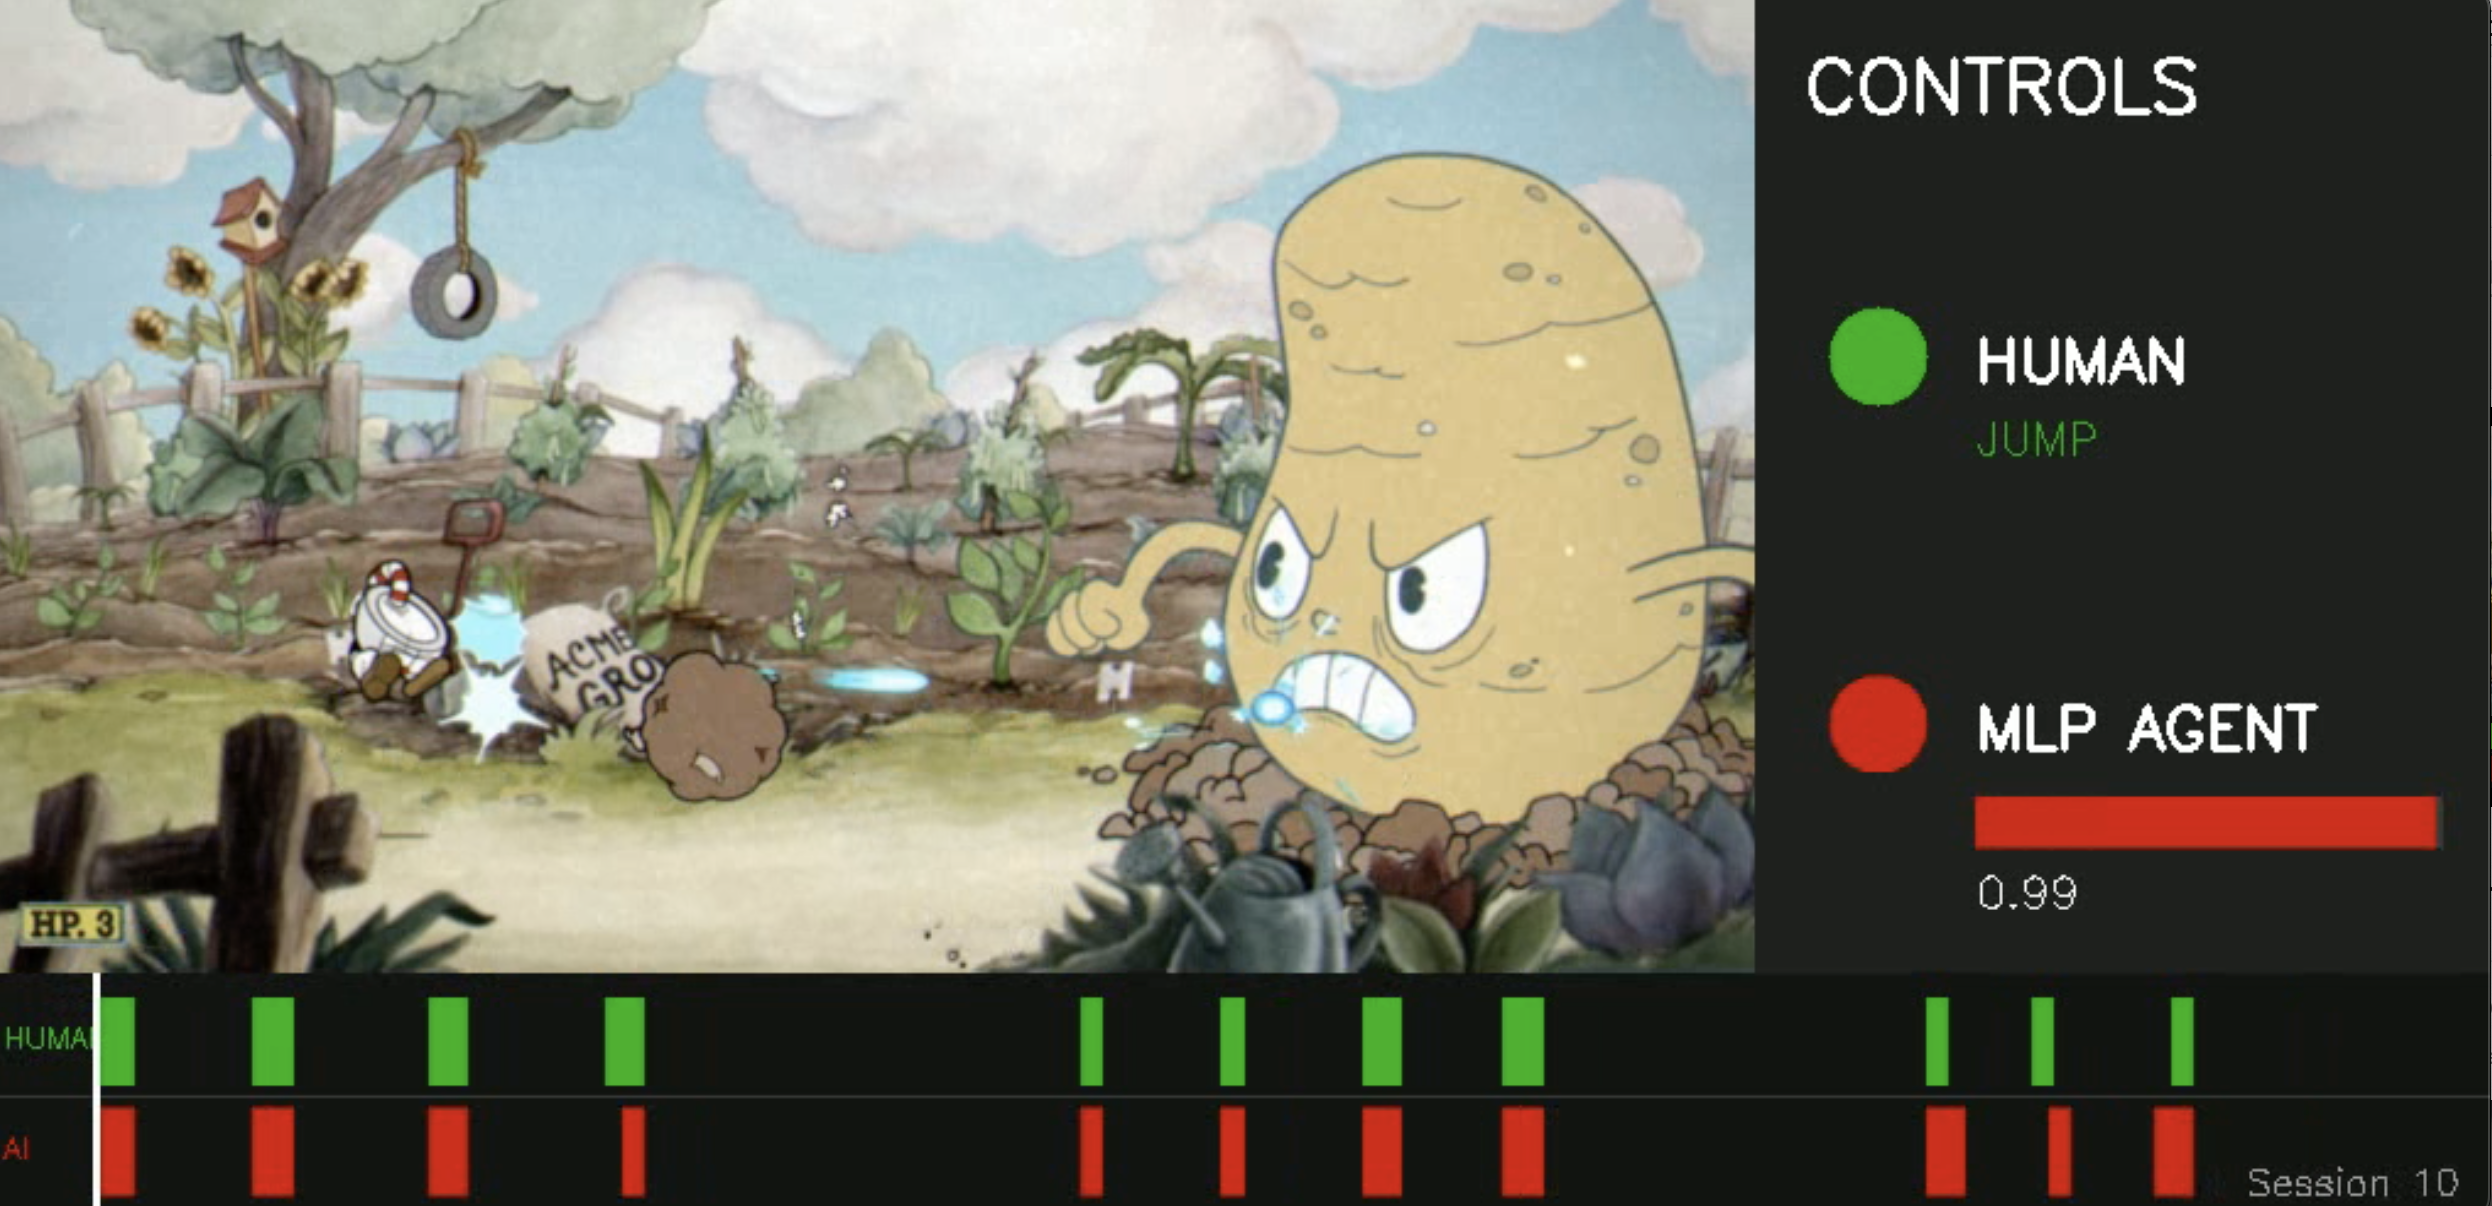 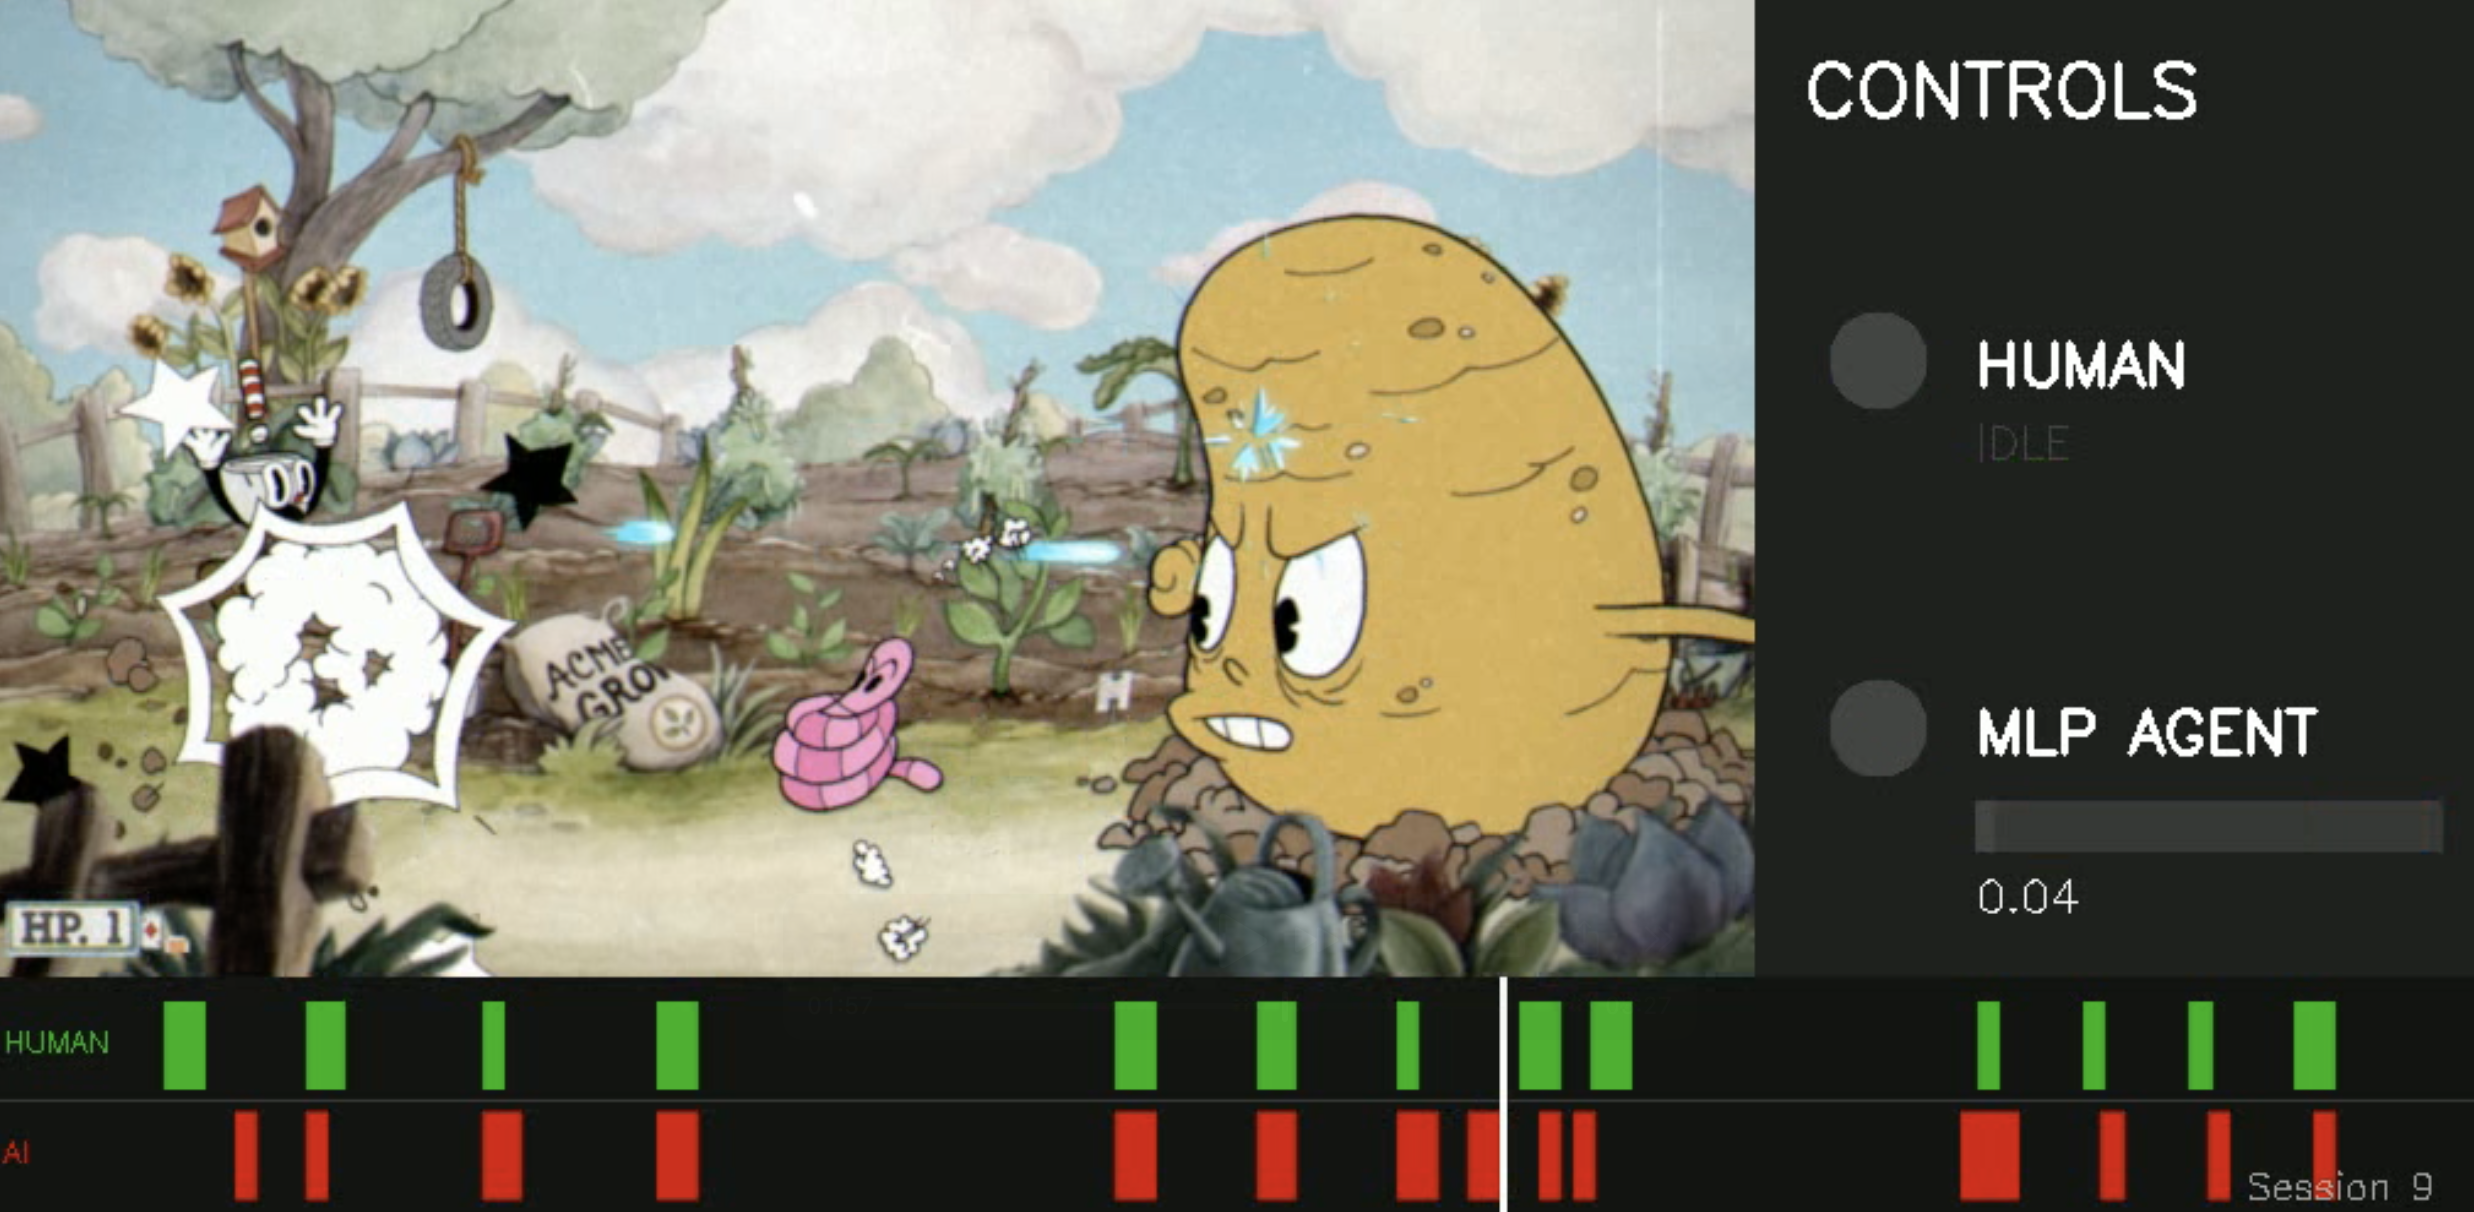
*Figure 4: Comparison of Sessions 10 (Stable) and 9 (Reactive). Persistent AI output during the human player's collision in Session 9 proves the agent reacts to real-time visual states rather than memorizing timing.*


**1. Perfect Run (Session 10)**

As shown in **Figure 4 (Top)**, Session 10 represents a standard "No Hit" performance.
*   The screenshot captures the player executing a clean jump over the projectile, maintaining a safe distance.
*   *The synchronization between the Human (Green) and AI (Red) is highly stable. The AI successfully clones the expert behavior, predicting jump actions with high temporal overlap. This confirms that under optimal conditions, the model faithfully replicates the expert policy.

**2. Failed Run (Session 9)**

Session 9 acts as an unintentional robustness test. During this session, the human player made an error and collided with the projectile.
*   The screenshot in **Figure 4 (Bottom)** captures the exact moment of failure; the "damage stars" and white impact explosion are visible, and the player character is stunned (unable to move).
*   The timeline reveals a chaotic pattern. The Human input (Green) becomes erratic due to the collision. However, the AI (Red) **does not stop reacting.** Crucially, the AI detects that the projectile is still within the "danger zone" and continues to output high-probability "JUMP" commands.


**Conclusion**

If the model were simply memorizing the timing of a level, it would have desynchronized or ceased outputting coherent actions after the collision disrupted the game flow. The fact that the Agent continues to recommend valid survival actions (Jumping) based on the proximity of the threat—even when the human player has failed—proves that the pipeline is successfully operating as a reactive physics engine ($Action = f(State)$).
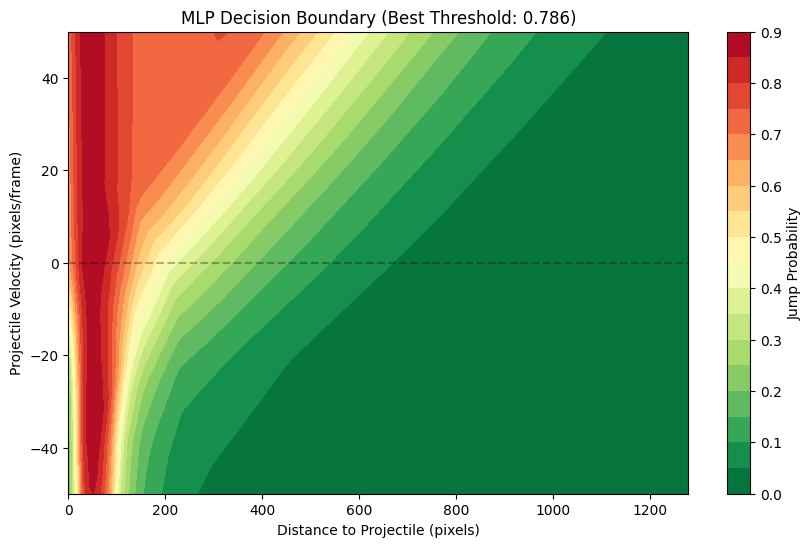
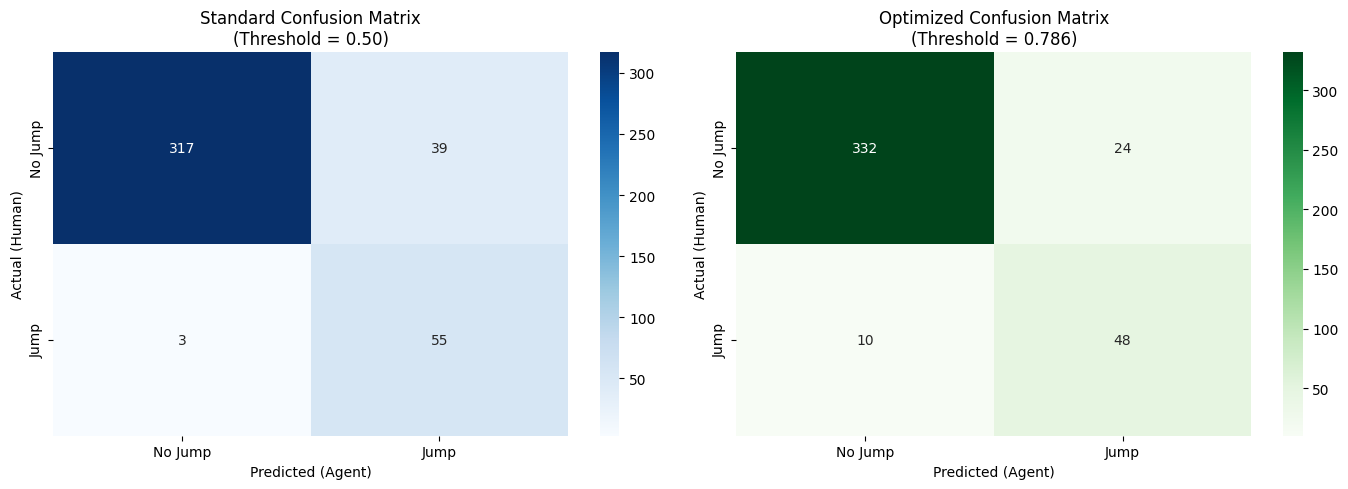
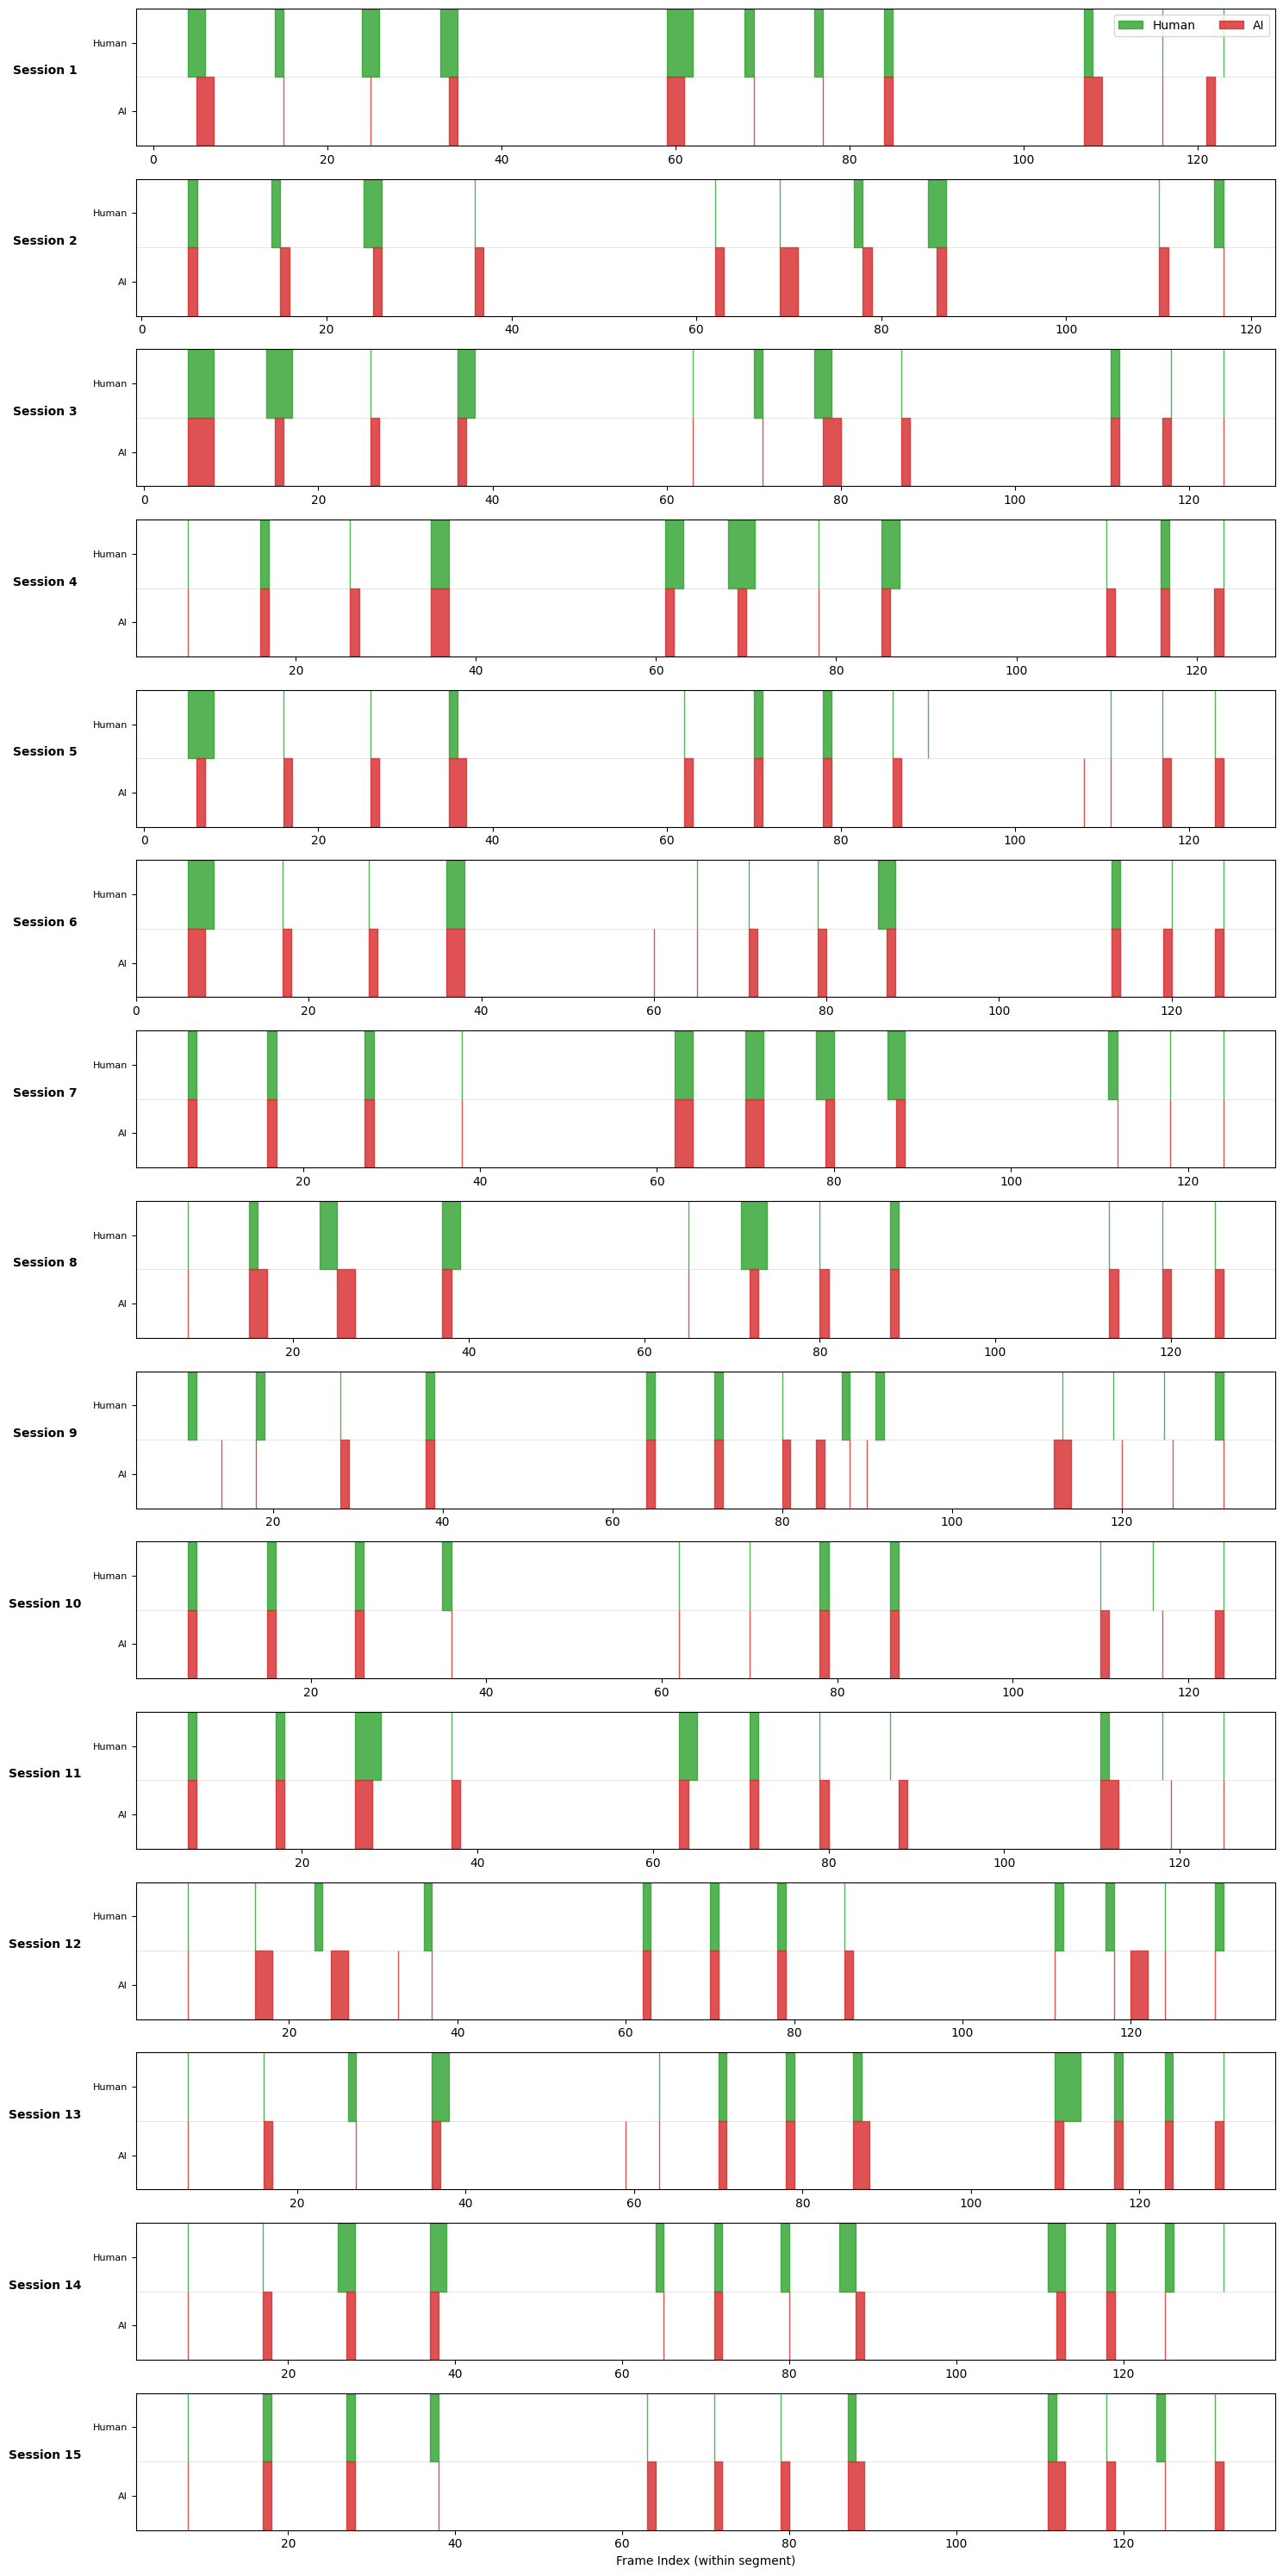

# appendix


 ### 1. Custom Segmentation Tooling
Standard video editing tools were insufficient because I needed to preserve the exact millisecond alignment between video frames and the asynchronous keystroke logs (UTC timestamps).

To solve this, I developed a custom Python utility, `mark_potato_segments.py`, which utilizes OpenCV and the original `_frames.jsonl` log file.
*   **Frame-Accurate Navigation:** The tool allowed me to step through the raw training video frame-by-frame.
*   **Metadata Tagging:** I manually identified the start (the moment the "Fight!" banner disappears) and end (the moment the Potato retreats) of every Potato phase across all 15 sessions.
*   **UTC Extraction:** Instead of cutting the video files (which risks re-encoding artifacts and frame drift), the tool generated a lightweight JSON metadata file (`potato_phase_segments.json`).

**Segment Metadata Structure:**
```json
{
    "id": 1,
    "start_frame": 450,
    "start_utc": 1763997299.05,
    "end_frame": 1200,
    "end_utc": 1763997324.10
}
```

### 2. Dataset Filtering
Using this metadata, I created a filtered dataset generator. During training, the data loader reads the JSON segments and only yields frames and keystrokes that fall strictly within the active Potato Phase combat windows. This reduced the dataset size but drastically increased data quality, ensuring the model only learns from relevant combat frames.

AI statement


reference

# **Project Title: Neural Architectures for Playing Cuphead**
**Subtitle:** Behavioral Cloning (Explicit vs. Implicit) vs. Reinforcement Learning

---

## **1. Introduction**
*   **1.1 Project Objective:** Instead of a theoretical research question, the goal is practical: **Build an autonomous agent capable of surviving the "Potato Phase" in Cuphead.**
*   **1.2 The Evolution (Professor’s Feedback):** 
    *   Building on Assignment 2, this project moves from simple classification to **Behavioral Cloning** (mimicking a "Perfect Run") and **Generative Sequence Modeling** (predicting the flow of the game).
*   **1.3 The Three Approaches:**
    *   **Pipeline A:** Explicit Perception (YOLO + MLP). "See object $\to$ Calculate Physics $\to$ Jump."
    *   **Pipeline B:** Implicit Perception (Autoencoder + GRU). "See Pixels $\to$ Feel Flow $\to$ Jump."
    *   **Pipeline C:** Reinforcement Learning (Unity). "Random Action $\to$ Get Reward $\to$ Learn Policy."

## **2. Data Curation: The "Potato Phase" Dataset**
*   **2.1 The Noise Challenge:** Raw gameplay contains menus, loading screens, and other bosses.
*   **2.2 Engineering Solution (Code Block):**
    *   Introduce `mark_potato_segments.py`.
    ## put this to appendix
    *   Explain how it extracts only the relevant combat frames and aligns them with UTC keystrokes.
    *   *Result:* A clean, filtered dataset for Training (15 sessions) and Validation (1 Perfect Run).

---

## **3. Pipeline A: Explicit Perception (The Novel Technique)**
*   **3.1 Concept:** Decoupling Vision from Decision. If we know *exactly* where the bullet is, the decision to jump should be mathematically simple.
*   **3.2 Mathematical Underpinnings:**
    *   **YOLO Loss Function:** Explain the Bounding Box Regression Loss (CIoU) and Classification Loss used to train the vision model.
    *   **Feature Engineering:** Define the State Vector $S_t$ constructed from the boxes:
        $$ S_t = [ \Delta x, \Delta y, v_x, v_y ] $$
        Where $v_x$ is the calculated velocity between frames $t$ and $t-1$.
*   **3.3 Implementation:**
    *   **Data Labeling:** The process of annotating 50-150 frames in Roboflow.
    *   **Vision Training:** Fine-tuning YOLOv8n.
    *   **Decision Model:** A simple Multi-Layer Perceptron (MLP) trained to map $S_t \to Action$.
*   **3.4 Results & Evaluation:**
    *   **Vision Metrics:** F1-Confidence Curve (proving 0.1 threshold is optimal).
    *   **Behavioral Metrics:** Precision/Recall on the Jump action.
    *   **Visual Proof:** The "Laser Measurement" video overlay showing the agent tracking distance.

---

## **4. Pipeline B: Implicit Perception (The Baseline Generator)**
*   **4.1 Concept:** End-to-End Deep Learning. The model must learn to "see" and "plan" solely from raw pixels, without being told what a "bullet" is.
*   **4.2 Mathematical Underpinnings:**
    *   **Manifold Learning:** Explain how the Autoencoder compresses the high-dimensional image space ($R^{9216}$) into a low-dimensional latent manifold ($z \in R^{512}$).
    *   **Sequence Modeling (GRU):** Explain the Gated Recurrent Unit equations ($z_t, r_t, h_t$) and why it is chosen over LSTM for this dataset size (less parameters, less overfitting).
*   **4.3 Implementation:**
    *   **Retraining:** Training the CAE on the specific Potato dataset (to sharpen the reconstruction of dirt clods).
    *   **The "Generator":** Setting up the GRU to run in a loop, taking the current frame and its own hidden state to generate the next action.
*   **4.4 Results & Evaluation:**
    *   **Latent Space PCA:** Visualizing if "Jump" frames cluster differently than "Idle" frames.
    *   **Performance:** Confusion Matrix and F1 Score comparison against Pipeline A.

---

## **5. Pipeline C: Pure Reinforcement Learning (Unity Simulation)**
*   **5.1 Concept:** Tabula Rasa. Instead of cloning a human (which clones human error), we let an agent learn the *optimal* policy through trial and error in a simulated physics environment.
*   **5.2 Mathematical Underpinnings:**
    *   **Markov Decision Process (MDP):** Define the Tuple $(S, A, R, P, \gamma)$.
    *   **PPO (Proximal Policy Optimization):** Explain the Clipped Surrogate Objective function used to update the policy $\pi_\theta$:
        $$ L^{CLIP}(\theta) = \hat{E}_t [ \min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) ] $$
    *   **Reward Function:** Define the equation for $R_t$ (e.g., +1 per second alive, -10 for collision).
*   **5.3 Implementation:**
    *   **The Greybox:** Recreating the Potato Boss physics (projectile speed, jump gravity) in Unity.
    *   **Training:** Using ML-Agents to train the brain.
*   **5.4 Results & Evaluation:**
    *   **Learning Curve:** Plot of Cumulative Reward vs. Training Steps.
    *   **Behavior:** Does it learn to jump? Does it discover strategies the human didn't use?

---

## **6. Final Discussion & Comparative Analysis**
*   **6.1 The "Generator" Test:**
    *   Comparing the three models side-by-side on the same video feed.
    *   *Pipeline A:* Rigid, precise, but fails if YOLO misses a frame.
    *   *Pipeline B:* Smoother, "human-like" jitter, but struggles with fast objects.
    *   *Pipeline C:* The theoretical upper bound (if the simulation is accurate).
*   **6.2 Verdict:** Which model is actually best for playing the game?
    *   *Argument:* Pipeline A (YOLO) is the most robust for this specific "reaction" task because it enforces semantic consistency.
*   **6.3 Future Work:** Merging them (using YOLO states as input for the RL agent).

## **7. Executive Summary**
*   A concise 1-page overview of the entire project flow.
*   **Visual:** A large diagram showing the three parallel paths (A, B, C) and their outcomes.

## **8. References**

---

## **Appendices**
*   **Appendix A:** YOLO Training Logs & Charts.
*   **Appendix B:** Model B (CAE+GRU) Architecture Summary.
*   **Appendix C:** Unity C# Scripts for Agent Logic.
*   **Appendix D:** Data Tools (`mark_potato_segments.py`).